# Example-04: Frequency

In [1]:
# In this example estimation of frequencies is illustrated

# Frequency and its several derivatives are computed for a simple 2D symplectic mapping
# Derivatives are used to perform local Taylor approximations
# Result is also compared with an analytical expression obtained from square matrix method

In [2]:
# Import

import numpy

from tqdm import tqdm

import jax
from jax import jit
from jax import vmap
from jax import jacrev
from jax import jacfwd

# Test symplectic mapping and corresponding inverse

from tohubohu.util import forward4D
from tohubohu.util import inverse4D

# Exponential window

from tohubohu import exponential

# Frequency factory

from tohubohu import frequency

# Plotting

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.ticker as ticker

mpl.rcParams['text.usetex'] = True

In [3]:
# Set data type

jax.config.update("jax_enable_x64", False)

In [4]:
# Set device

device, *_ = jax.devices('cpu')
jax.config.update('jax_default_device', device)

In [5]:
# SMM frequency expression (perturbation theory)

def smm(q):
    return 0.238052160264804580       \
         - 0.015200217416172931*q**2  \
         + 0.017861595083634475*q**3  \
         + 0.231845856974195660*q**4  \
         - 0.590356798331802200*q**5  \
         + 0.730726019348640000*q**6  \
         + 0.188262070017530800*q**7  \
         - 3.928891073096105300*q**8  \
         + 11.87833362636719600*q**9  \
         - 45.76399509742608000*q**10 \
         + 157.4981904151539000*q**11 \
         - 478.8969677720342000*q**12 \
         + 1177.620316624183000*q**13 \
         - 3147.297909882562000*q**14 \
         + 10163.25232807885200*q**15 \
         + 4648.468950619761000*q**16

In [6]:
# Mapping

@jit
def mapping(x, k):
    q, p = x
    w, a, b = k
    return jax.numpy.stack([p, -q + w*p + a*p**2 + b*p**3])

In [7]:
# Define parameters and test mapping

x = jax.numpy.array([0.0, 0.0])
k = jax.numpy.array([0.15, 1.25, -0.5])

mapping(x, k)

Array([0., 0.], dtype=float32)

In [8]:
# Set window

n = 2**10
ws = exponential(n)

In [9]:
# Set initial conditions

qs = jax.numpy.linspace(-0.350, 0.525, 2**10)
ps = jax.numpy.copy(qs)
xs = jax.numpy.stack([qs, ps]).T

In [10]:
# Set frequency factory

fn = frequency(ws, mapping)

In [11]:
# Compute frequencies for given initials

out = vmap(fn, (0, None))(xs, k).squeeze()
mat = smm(qs)

In [12]:
# Compute frequencies at a coarse grid along with several derivatives
# Note, frequency can't be computed at the origin

Qs = jax.numpy.array([-0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4])
Ps = jax.numpy.copy(Qs)
Xs = jax.numpy.stack([Qs, Ps]).T

Fs = []
for X in Xs:
    f0 = fn(X, k).squeeze()
    f1 = jacrev(fn)(X, k).squeeze()
    f2 = jacrev(jacrev(fn))(X, k).squeeze()
    f3 = jacrev(jacrev(jacrev(fn)))(X, k).squeeze()
    f4 = jacrev(jacrev(jacrev(jacrev(fn))))(X, k).squeeze()
    f5 = jacrev(jacrev(jacrev(jacrev(jacrev(fn)))))(X, k).squeeze()
    fs = [f0, f1, f2, f3, f4, f5]
    Fs.append(fs)

In [13]:
# Series evaluation function

def evaluate(fs, x):
    f0, f1, f2, f3, f4, f5 = fs
    return f0 + \
           1/1         * f1 @ x + \
           1/2         * f2 @ x @ x + \
           1/(2*3)     * f3 @ x @ x @ x + \
           1/(2*3*4)   * f4 @ x @ x @ x @ x + \
           1/(2*3*4*5) * f5 @ x @ x @ x @ x @ x

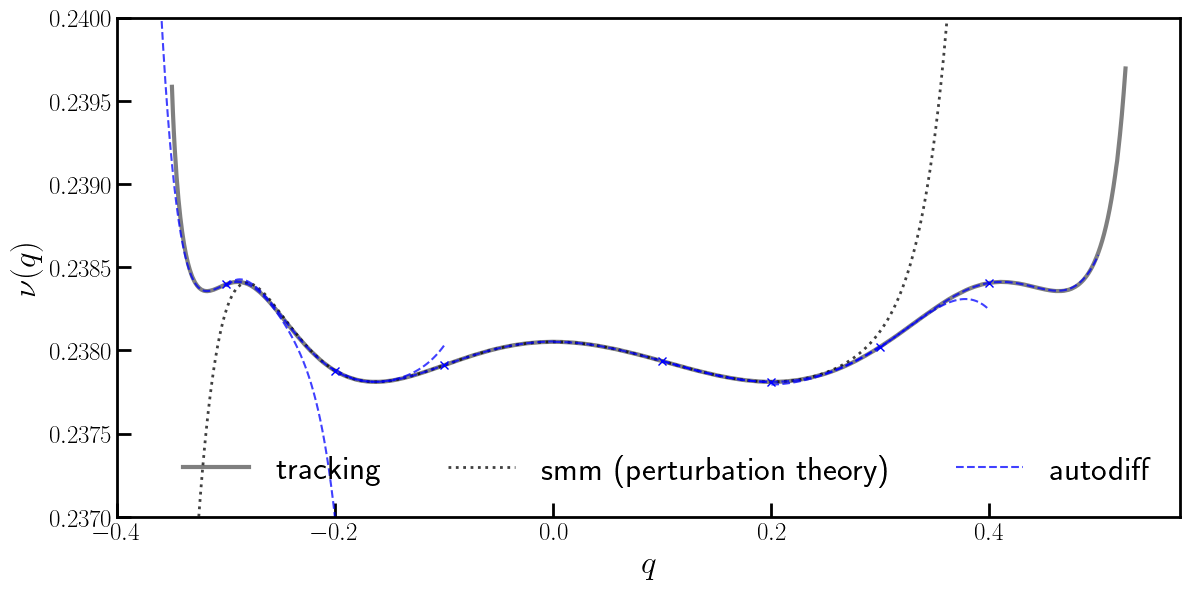

In [14]:
# Plot

flag = True
line = jax.numpy.linspace(-0.1, 0.1, 101)
line = jax.numpy.stack([line, line]).T
plt.figure(figsize=(12, 6))
ax = plt.subplot(111)
ax.errorbar(qs, out, color='black', marker=None, fmt='-', lw=3.0, label='tracking', alpha=0.50, zorder=0)
ax.errorbar(qs, mat, color='black', fmt=':', marker=None, lw=2.0, label='smm (perturbation theory)', alpha=0.75, zorder=1)
for X, fs in zip(Xs, Fs):
    q, p = X
    plt.errorbar(q, evaluate(fs, 0*X), marker='x', fmt=' ', color='blue', ms=6)    
    x, *_ = (X + line).T
    y = vmap(evaluate, (None, 0))(fs, line)
    if flag:
        flag = False
        plt.errorbar(x, y, color='blue', fmt='--', marker=None, label='autodiff', alpha=0.75)
    else:
        plt.errorbar(x, y, color='blue', fmt='--', marker=None, alpha=0.75)
ax.set_xlim(-0.350 - 0.05, 0.525 + 0.05)
ax.set_ylim(0.2370, 0.2400)
ax.tick_params(width=2, labelsize=18)
ax.tick_params(axis='x', length=10, direction='in')
ax.tick_params(axis='y', length=10, direction='in')
ax.set_ylabel(r'$\nu (q)$', fontsize=24)
ax.set_xlabel(r'$q$', fontsize=24)
plt.legend(loc=4, ncol=3, frameon=False, prop={'size': 24})
plt.setp(ax.spines.values(), linewidth=2.0)
plt.tight_layout()
plt.show()